### 01 — Exploratory Data Analysis (EDA)

**Local data source:** `/data/interim/10kDiabetes.csv`

## Executive Summary

This notebook performs an initial sweep of the Diabetes Readmission dataset.

**Findings:**
- The dataset is highly imbalanced, with far fewer readmissions than non-readmissions. 
  This makes ROC-AUC less informative and increases the importance of PR-AUC.

- Many features are categorical (e.g., admission source/type, discharge disposition, race, gender), 
  requiring one-hot encoding for classical ML models.

- Several numerical features (e.g., number of inpatient visits, emergency visits, diagnoses) 
  show long-tailed distributions and strong predictive potential.

- ICD-9 diagnostic codes are messy and high-cardinality; each patient has three diagnosis fields, 
  and codes range from broad categories to highly granular subcodes.  
  This leads to a very sparse and wide feature space if one-hot encoded directly.
  I explore this more in [[03_ICD9_feature_engineering_prototype](./03_ICD9_feature_engineering_prototype.ipynb)] and [[04_Model-v2.ipynb](./04_Model-v2.ipynb)].  

- Missingness varies substantially by field; some categorical features (e.g., medical specialty)
  contain large proportions of ‘Unknown’ or ‘Missing’ values.

- Preliminary relationships (e.g., higher inpatient/emergency visit counts) suggest clinically 
  plausible drivers of readmission that will be explored further in [[02_Model.ipynb](./02_Model.ipynb)].

#### 1. Imports and Project Setup

In [1]:
import sys
import os

project_root = os.path.abspath("..") # Add project root to Python path so we can import data_loader etc etc
if project_root not in sys.path:
    sys.path.append(project_root)

project_root

'C:\\work\\git\\diabetes-readmission-ml'

In [66]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore") # Not too bothered about message "Pyarrow will become a required dependency of pandas"
    import pandas as pd
    from IPython.core.display import display, HTML

import numpy as np
import missingno as msno
import re
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.4)  # try 1.3–1.6

from src.data_loader import load_diabetes_csv, DIABETES_DATA_CSV

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

In [3]:
df = load_diabetes_csv(DIABETES_DATA_CSV,project_root)
df.shape

(10000, 52)

In [4]:
df.head()

,rowID,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,diag_1_desc,diag_2_desc,diag_3_desc
0,1,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1,CP,Surgery-Neuro,35,4,21,0,0,0,723,723,719,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,False,Spinal stenosis in cervical region,Spinal stenosis in cervical region,"Effusion of joint, site unspecified"
1,2,Caucasian,Female,[20-30),[50-75),Urgent,Discharged to home,Physician Referral,2,UN,?,8,5,5,0,0,0,664,648,285,6,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,False,"First-degree perineal laceration, unspecified ...","Diabetes mellitus of mother, complicating preg...",Sideroblastic anemia
2,3,Caucasian,Male,[80-90),?,Not Available,Discharged/transferred to home with home healt...,NaN,7,MC,Family/GeneralPractice,12,0,21,0,0,1,481,428,276,9,>200,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,True,Pneumococcal pneumonia [Streptococcus pneumoni...,"Congestive heart failure, unspecified",Hyperosmolality and/or hypernatremia
3,4,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Transfer from another health care facility,4,UN,?,33,1,5,0,0,0,682,41,250,3,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,False,Cellulitis and abscess of face,Streptococcus infection in conditions classifi...,Diabetes mellitus without mention of complicat...
4,5,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,5,?,Psychiatry,31,0,13,0,0,0,296,250.01,298,7,NaN,NaN,Steady,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,False,"Bipolar I disorder, single manic episode, unsp...",Diabetes mellitus without mention of complicat...,Depressive type psychosis


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   rowID                     10000 non-null  int64 
 1   race                      10000 non-null  object
 2   gender                    10000 non-null  object
 3   age                       10000 non-null  object
 4   weight                    10000 non-null  object
 5   admission_type_id         9279 non-null   object
 6   discharge_disposition_id  9531 non-null   object
 7   admission_source_id       9064 non-null   object
 8   time_in_hospital          10000 non-null  int64 
 9   payer_code                10000 non-null  object
 10  medical_specialty         10000 non-null  object
 11  num_lab_procedures        10000 non-null  int64 
 12  num_procedures            10000 non-null  int64 
 13  num_medications           10000 non-null  int64 
 14  number_outpatient      

This summary shows:
- column data types (yes there are 50 columns, plus a numerical index!)
- missingness structure  
- categorical vs numerical balance 

## Which fields have missing values/NaNs?

In [6]:
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]
missing_df = (
    missing.to_frame(name="num_missing")
        .assign(
            pct_missing=lambda x: (x["num_missing"] / len(df) * 100).round(2),
            pct_present=lambda x: 100 - x["pct_missing"]
        )
)
print(f"\nNumber of rows: {df.shape[0]}")
missing_df


Number of rows: 10000


,num_missing,pct_missing,pct_present
max_glu_serum,9336,93.36,6.64
A1Cresult,8379,83.79,16.21
admission_source_id,936,9.36,90.64
admission_type_id,721,7.21,92.79
discharge_disposition_id,469,4.69,95.31
diag_3_desc,208,2.08,97.92
diag_2_desc,59,0.59,99.41
diag_1_desc,2,0.02,99.98
examide,0,0.00,100.00
tolbutamide,0,0.00,100.00


## Heatmap of missing values

<Figure size 1600x1600 with 0 Axes>

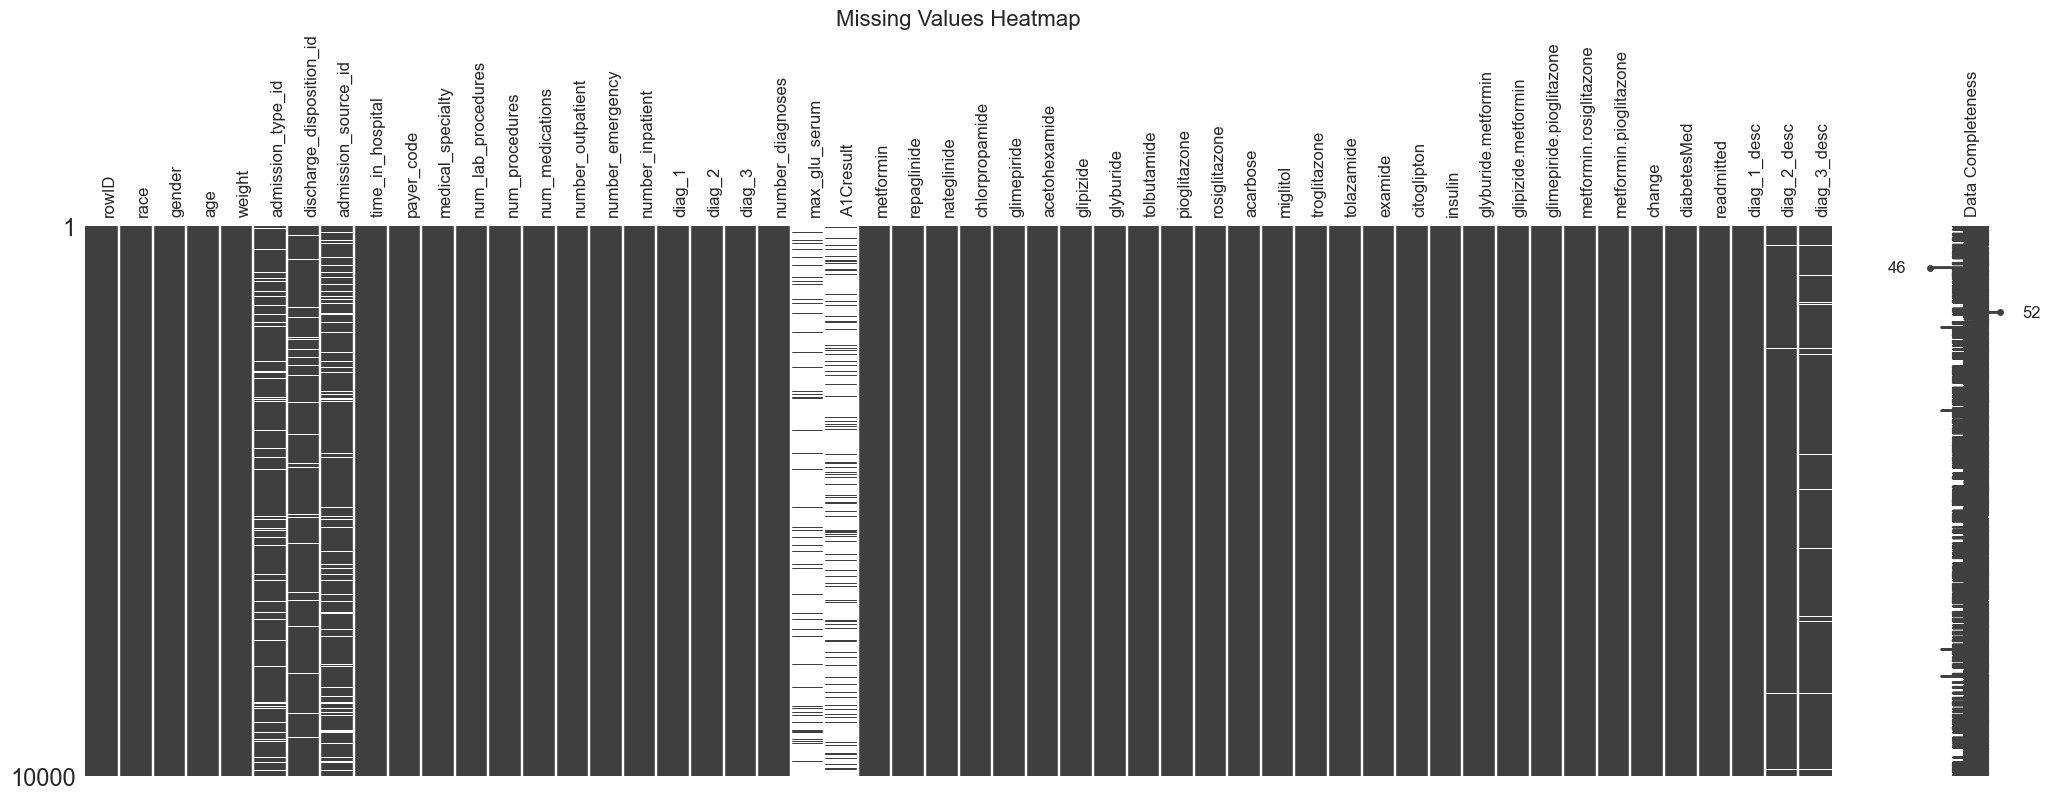

In [7]:
plt.figure(figsize=(16, 16))

ax = msno.matrix(  # Missingness matrix
    df,
    labels=True,
    fontsize=14,  
)

fig = plt.gcf()
fig.canvas.draw()

for artist in fig.findobj(match=plt.Text):
    if artist.get_text() == "Data Completeness":
        artist.set_rotation(90)
        artist.set_fontsize(12)
        artist.set_horizontalalignment('left')
        artist.set_verticalalignment('bottom')

plt.xticks(rotation=90, fontsize=12)
plt.title("Missing Values Heatmap", fontsize=16)
plt.subplots_adjust(bottom=0.35, top=0.90)
plt.show()

Data completeness is actually pretty good, with the notable exception of fields **max_glu_serum** and **A1Cresult**.

There appears to be no particular clustering when it comes to missing data attributes.

Given the low overall missingness, I am pretty confident in using simple imputation -- nothing complex needed here!

## Target Distribution (Binary Readmission Flag)

Check the Boolean variable we're trying to predict for how well it is balanced across the dataset

In [8]:
target_col = "readmitted"
pct = df[target_col].value_counts(normalize=True).mul(100).round(2)
pct_df = pct.rename("pct").astype(str) + '%'
pct_df.to_frame()

,pct
readmitted,
False,60.35%
True,39.65%


N.B. 60/40 is not too much of an imbalance. But we will go carefully, being mindful of Type I/Type II statistical errors.

**We should be particularly cautious about false negatives**, which have both clinical and operational implications: if a patient is at risk of readmission, we don’t want the model to miss them - we have a **duty of care** to patients.

## Investigate numerical features

In [9]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if "rowID" in numeric_cols:
    numeric_cols.remove("rowID")

df_numeric = df[numeric_cols]
df_numeric.describe().T

,count,mean,std,min,25%,50%,75%,max
time_in_hospital,10000.0,4.4347,3.021597,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,10000.0,43.0786,19.453315,1.0,32.0,44.0,57.0,120.0
num_procedures,10000.0,1.3992,1.706438,0.0,0.0,1.0,2.0,6.0
num_medications,10000.0,15.5638,8.391613,1.0,10.0,14.0,19.0,81.0
number_outpatient,10000.0,0.2817,1.119406,0.0,0.0,0.0,0.0,36.0
number_emergency,10000.0,0.1150,0.649475,0.0,0.0,0.0,0.0,42.0
number_inpatient,10000.0,0.3873,0.854267,0.0,0.0,0.0,0.0,10.0
number_diagnoses,10000.0,7.0253,2.020957,1.0,5.0,7.0,9.0,9.0


No missing values. I can use this.

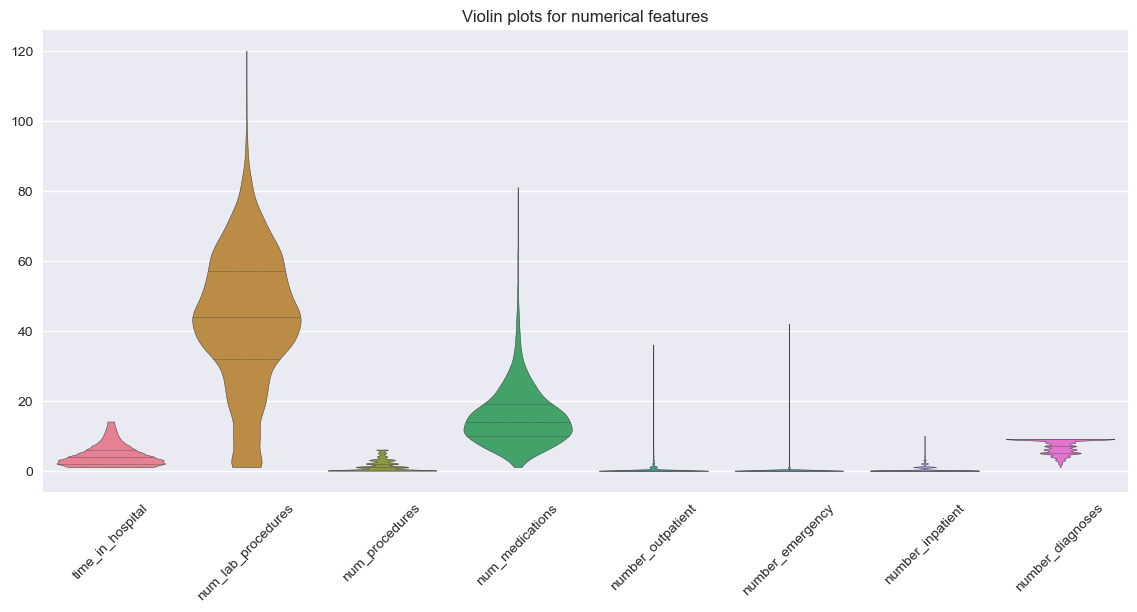

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.violinplot(data=df_numeric, inner='quartile', cut=0)
plt.title("Violin plots for numerical features")
plt.xticks(rotation=45)
plt.show()

### Let's see the distributions separately for (i) patients who were readmitted, and (b) patients who weren't.

In [11]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "rowID"]

df_long = df.melt(
    id_vars="readmitted",
    value_vars=numeric_cols,
    var_name="feature",
    value_name="value"
)

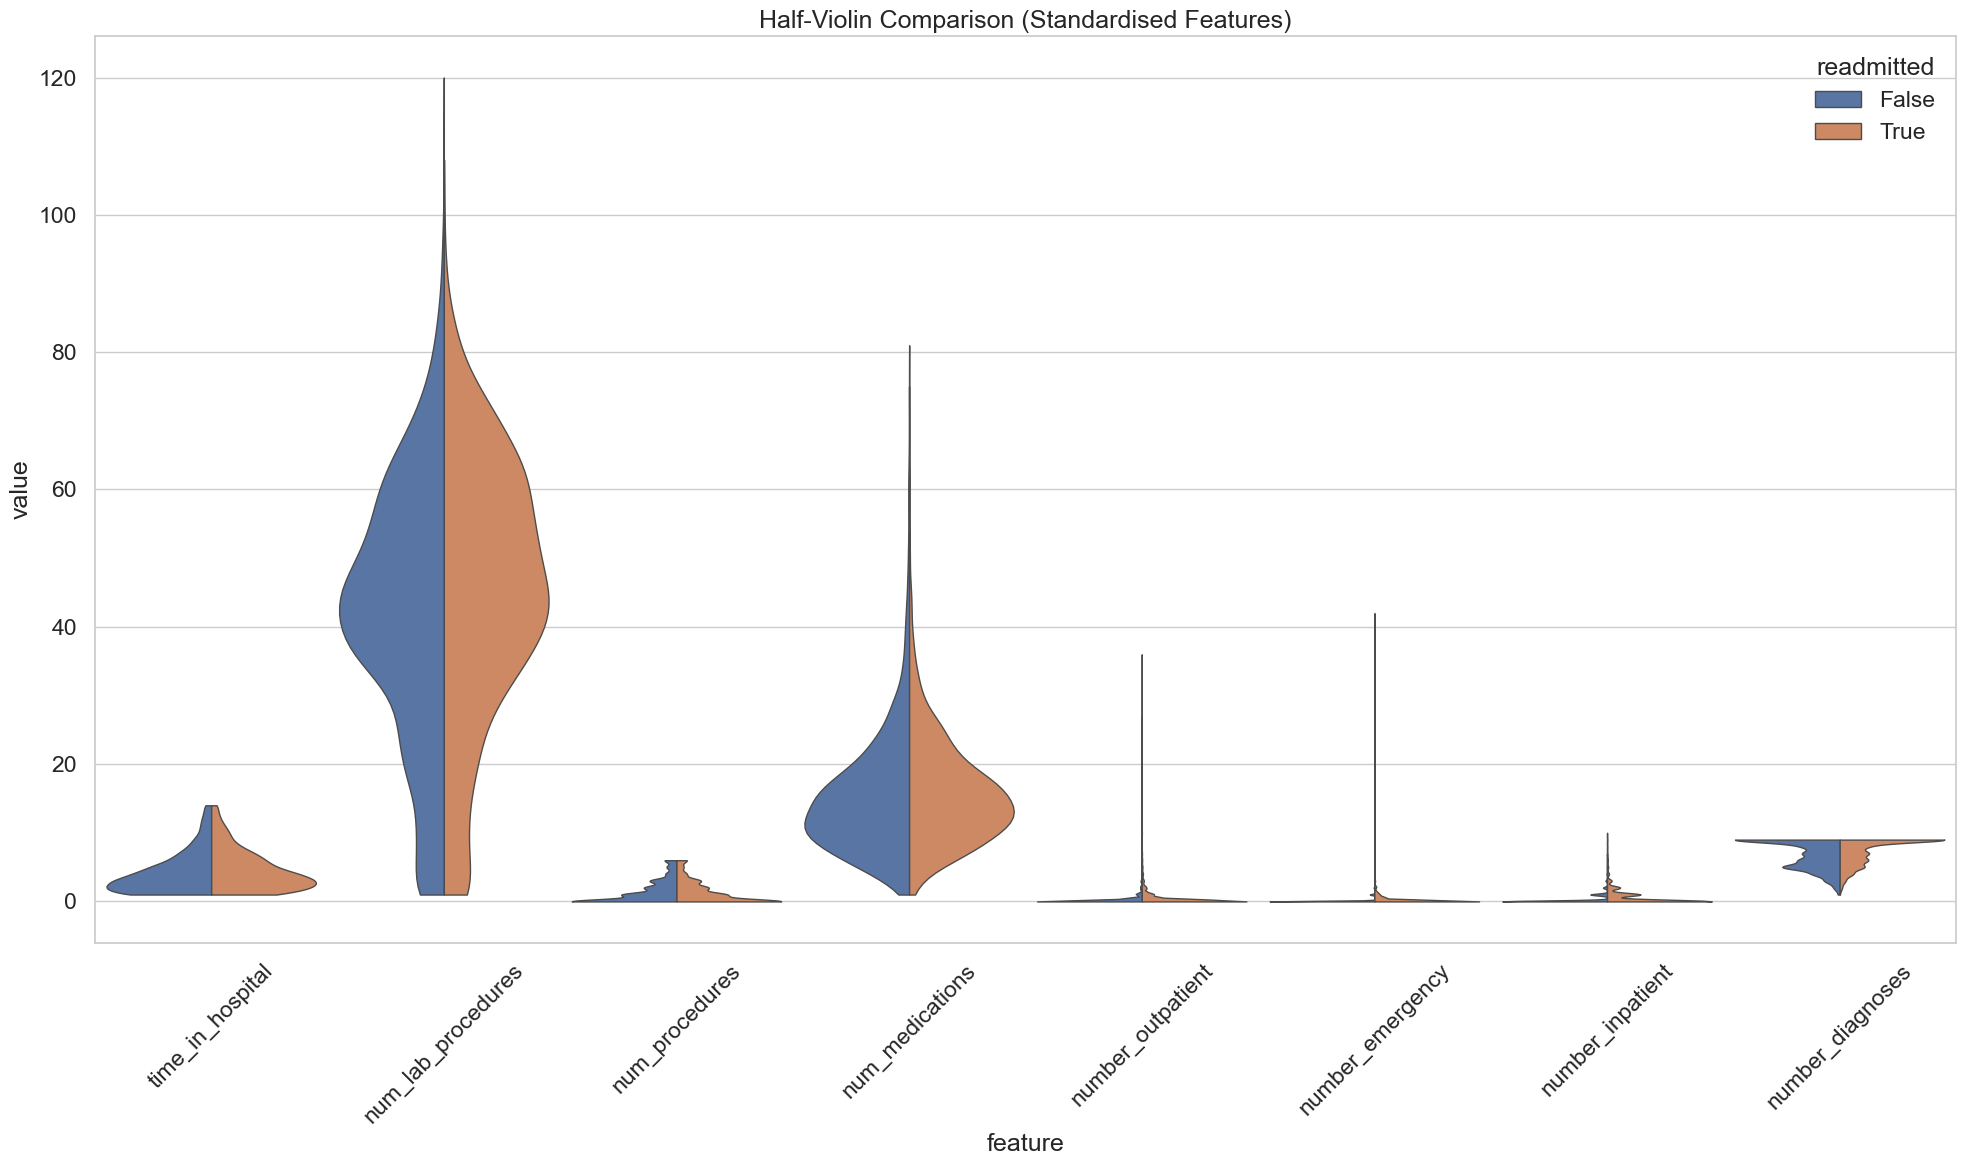

In [12]:
from sklearn.preprocessing import MinMaxScaler

numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "rowID"]

scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df_long_scaled = df_scaled.melt(
    id_vars="readmitted",
    value_vars=numeric_cols,
    var_name="feature",
    value_name="value"
)

sns.set_theme(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(20, 12))

sns.violinplot(
    data=df_long,
    x="feature",
    y="value",
    hue="readmitted",
    split=True,
    inner=None,
    cut=0,
    width=0.9,        # <-- MUCH WIDER VIOLINS
    density_norm="count",    # <-- Uses sample size to expand violins
    bw_adjust=1.2,    # <-- optional smoothing
    linewidth=1.0,
)

plt.title("Half-Violin Comparison (Standardised Features)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Patients who are readmitted tend to have more lab procedures, medication counts skewed slightly highly, and slightly longer hospital stays.

This early stage view suggests that the greater interaction with hospital procedures, _possibly_ the higher the risk of readmission.

In [13]:
cols = ['readmitted', 'time_in_hospital', 'num_lab_procedures', 'num_medications']
df_sub = df[cols]

summary = (
    df_sub
    .groupby('readmitted')
    .agg(['mean', 'median', 'std', 'min', 'max']).T
)
summary

readmitted                      False       True 
time_in_hospital   mean      4.308534    4.626734
                   median    4.000000    4.000000
                   std       3.027208    3.003260
                   min       1.000000    1.000000
                   max      14.000000   14.000000
num_lab_procedures mean     41.791218   45.038083
                   median   43.000000   46.000000
                   std      19.244476   19.607779
                   min       1.000000    1.000000
                   max     120.000000  108.000000
num_medications    mean     15.261475   16.023960
                   median   14.000000   15.000000
                   std       8.650100    7.961194
                   min       1.000000    1.000000
                   max      75.000000   81.000000

In [14]:
summary2 = (
    df_sub
    .groupby('readmitted')
    .agg(['mean', 'median', 'std']).T
)
summary2.columns = ['Not_readmitted', 'Readmitted']
summary2['% Difference'] = (
    (summary2["Readmitted"] / summary2["Not_readmitted"] - 1) * 100
).round(1)

summary2['% Difference'] = summary2['% Difference'].astype(str) + '%' # Convert to string with % symbol
summary2

Not_readmitted  Readmitted % Difference
time_in_hospital   mean          4.308534    4.626734         7.4%
                   median        4.000000    4.000000         0.0%
                   std           3.027208    3.003260        -0.8%
num_lab_procedures mean         41.791218   45.038083         7.8%
                   median       43.000000   46.000000         7.0%
                   std          19.244476   19.607779         1.9%
num_medications    mean         15.261475   16.023960         5.0%
                   median       14.000000   15.000000         7.1%
                   std           8.650100    7.961194        -8.0%

## Categorical Cardinality

In [15]:
cat_cols = df.select_dtypes(include='object').columns          # Identify categorical columns (object dtype)
cardinality = (
    df[cat_cols]
    .nunique()
    .sort_values(ascending=False)
    .to_frame("unique_values")
)
cardinality.style.background_gradient(cmap="Blues")

,unique_values
diag_3,461
diag_3_desc,460
diag_1,458
diag_1_desc,457
diag_2,430
diag_2_desc,429
medical_specialty,53
discharge_disposition_id,21
payer_code,16
age,10


The cardinality of the diagnostic codes is going to need some attention.

Everything else looks very manageable.

Let's look at some of the categorical fields with mid-range cardinality.

In [16]:
df['medical_specialty'].unique().tolist()

['Surgery-Neuro',
 '?',
 'Family/GeneralPractice',
 'Psychiatry',
 'Cardiology',
 'InternalMedicine',
 'Surgery-Cardiovascular/Thoracic',
 'Nephrology',
 'Emergency/Trauma',
 'Gastroenterology',
 'Orthopedics',
 'Cardiology-Pediatric',
 'PhysicalMedicineandRehabilitation',
 'Gynecology',
 'Pulmonology',
 'Surgery-General',
 'Pediatrics',
 'Orthopedics-Reconstructive',
 'Surgery-Pediatric',
 'Otolaryngology',
 'Pediatrics-CriticalCare',
 'Hematology/Oncology',
 'ObstetricsandGynecology',
 'Pediatrics-Endocrinology',
 'Surgery-Vascular',
 'Urology',
 'Neurology',
 'Radiologist',
 'Osteopath',
 'Surgery-Cardiovascular',
 'Psychology',
 'Oncology',
 'Endocrinology',
 'OutreachServices',
 'Podiatry',
 'Ophthalmology',
 'Hospitalist',
 'Radiology',
 'Obsterics&Gynecology-GynecologicOnco',
 'Surgery-Thoracic',
 'Surgeon',
 'Pathology',
 'Surgery-Plastic',
 'InfectiousDiseases',
 'Anesthesiology-Pediatric',
 'Pediatrics-Pulmonology',
 'Pediatrics-Hematology-Oncology',
 'Hematology',
 'Surgery-

In [17]:
df['discharge_disposition_id'].unique().tolist()

['Discharged to home',
 'Discharged/transferred to home with home health service',
 'Expired',
 'Discharged/transferred to a long term care hospital.',
 'Discharged/transferred to SNF',
 'Discharged/transferred to another  type of inpatient care institution',
 'Not Mapped',
 'Discharged/transferred to another short term hospital',
 nan,
 'Left AMA',
 'Discharged/transferred to another rehab fac including rehab units of a hospital.',
 'Hospice / medical facility',
 'Hospice / home',
 'Discharged/transferred/referred to a psychiatric hospital of a psychiatric distinct part unit of a hospital',
 'Discharged/transferred to ICF',
 'Discharged/transferred to home under care of Home IV provider',
 'Admitted as an inpatient to this hospital',
 'Discharged/transferred/referred another institution for outpatient services',
 'Discharged/transferred to a federal health care facility.',
 'Discharged/transferred within this institution to Medicare approved swing bed',
 'Discharged/transferred/referr

In [18]:
str(df['payer_code'].unique().tolist())

"['CP', 'UN', 'MC', '?', 'HM', 'SP', 'CM', 'BC', 'MD', 'WC', 'OG', 'PO', 'DM', 'SI', 'OT', 'CH']"

`medical_specialty` is the only attribute with any real semantic complexity, but it’s still small enough for encoding.

## High level correlation overview ✈️

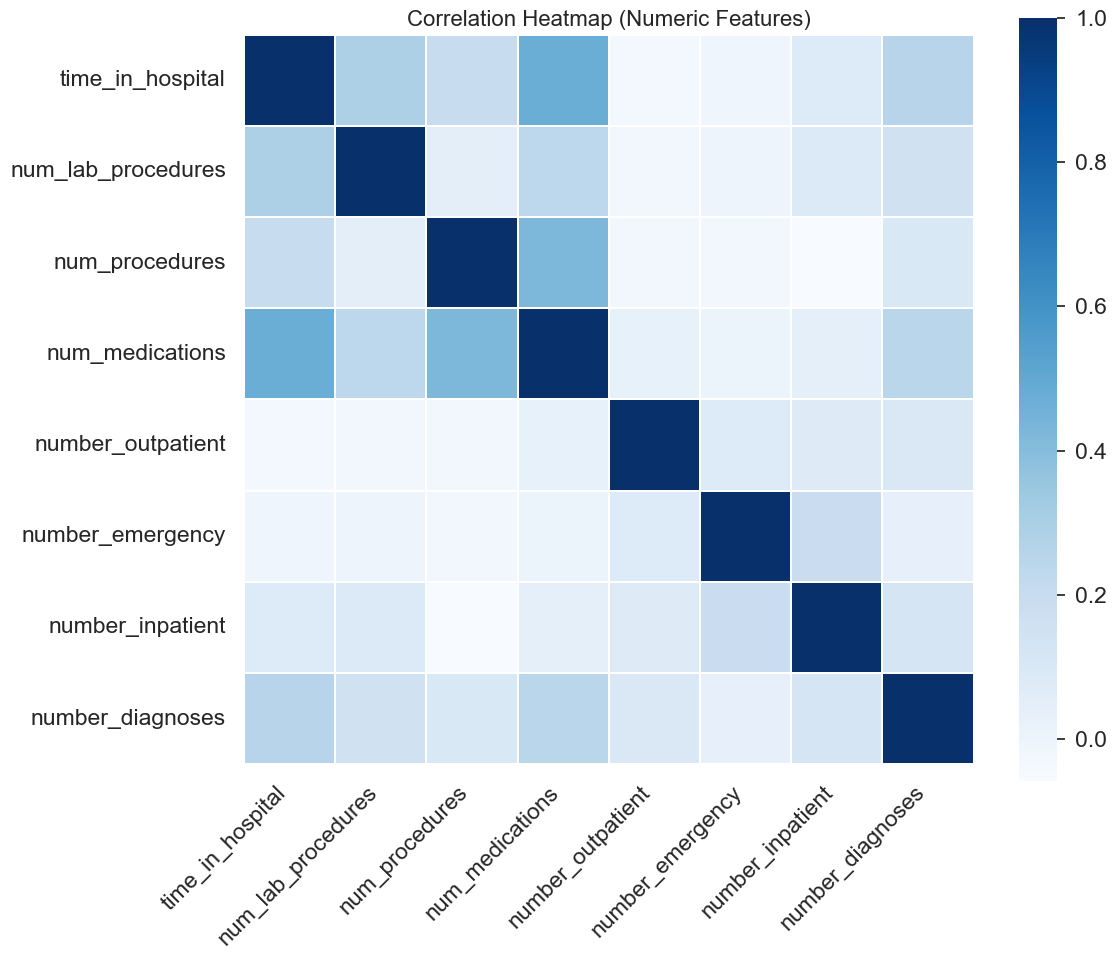

In [19]:
numeric_cols = list(df.select_dtypes(include=['int64', 'float64']).columns)
numeric_cols.remove('rowID')
corr = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap="Blues",
    annot=False,
    cbar=True,
    square=True,
    linewidths=0.3,
)

plt.title("Correlation Heatmap (Numeric Features)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

No notable off-diagonal correlation structure noted

In [20]:
corr = df[numeric_cols].corr().round(3)
corr

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
time_in_hospital,1.000,0.292,0.202,0.475,-0.033,-0.007,0.081,0.259
num_lab_procedures,0.292,1.000,0.054,0.236,-0.029,-0.001,0.087,0.152
num_procedures,0.202,0.054,1.000,0.424,-0.021,-0.026,-0.058,0.101
num_medications,0.475,0.236,0.424,1.000,0.026,0.007,0.044,0.251
number_outpatient,-0.033,-0.029,-0.021,0.026,1.000,0.083,0.076,0.095
number_emergency,-0.007,-0.001,-0.026,0.007,0.083,1.000,0.187,0.033
number_inpatient,0.081,0.087,-0.058,0.044,0.076,0.187,1.000,0.125
number_diagnoses,0.259,0.152,0.101,0.251,0.095,0.033,0.125,1.000


### Examine the diagnostic codes

In [21]:
str(df['diag_1'].unique().tolist()[:20])

"['723', '664', '481', '682', '296', '428', '434', '558', '440', '997', '250.8', '250.7', '584', '414', '250.82', '415', '432', '786', '410', '276']"

In [22]:
str(df['diag_2'].unique().tolist()[:20])

"['723', '648', '428', '41', '250.01', '427', '345', '562', '425', '998', '799', '440', '453', '486', '411', '707', '414', '581', '300', '157']"

In [23]:
str(df['diag_3'].unique().tolist()[:20])

"['719', '285', '276', '250', '298', '414', '584', '455', '70', '998', '511', '401', '707', '426', '496', '427', '731', '425', 'V45', '585']"

In [24]:
df['diag_1_desc'].unique()[:10].tolist()

['Spinal stenosis in cervical region',
 'First-degree perineal laceration, unspecified as to episode of care or not applicable',
 'Pneumococcal pneumonia [Streptococcus pneumoniae pneumonia]',
 'Cellulitis and abscess of face',
 'Bipolar I disorder, single manic episode, unspecified',
 'Congestive heart failure, unspecified',
 'Cerebral thrombosis without mention of cerebral infarction',
 'Other and unspecified noninfectious gastroenteritis and colitis',
 'Atherosclerosis of aorta',
 'Nervous system complication, unspecified']

In [25]:
df['diag_2_desc'].unique()[:10].tolist()

['Spinal stenosis in cervical region',
 'Diabetes mellitus of mother, complicating pregnancy, childbirth, or the puerperium, unspecified as to episode of care or not applicable',
 'Congestive heart failure, unspecified',
 'Streptococcus infection in conditions classified elsewhere and of unspecified site, streptococcus, unspecified',
 'Diabetes mellitus without mention of complication, type I [juvenile type], not stated as uncontrolled',
 'Paroxysmal supraventricular tachycardia',
 'Generalized nonconvulsive epilepsy, without mention of intractable epilepsy',
 'Diverticulosis of small intestine (without mention of hemorrhage)',
 'Endomyocardial fibrosis',
 'Postoperative shock, unspecified']

In [26]:
df['diag_3_desc'].unique()[:10].tolist()

['Effusion of joint, site unspecified',
 'Sideroblastic anemia',
 'Hyperosmolality and/or hypernatremia',
 'Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled',
 'Depressive type psychosis',
 'Coronary atherosclerosis of unspecified type of vessel, native or graft',
 'Acute kidney failure',
 'Internal hemorrhoids without mention of complication',
 'Viral hepatitis A with hepatic coma',
 'Postoperative shock, unspecified']

In [27]:
mask = ( (df['diag_1'] == '723') | (df['diag_2'] == '723') | (df['diag_3'] == '723') )
df_723 = df[mask][['diag_1','diag_1_desc','diag_2','diag_2_desc','diag_3','diag_3_desc']]
df_723

,diag_1,diag_1_desc,diag_2,diag_2_desc,diag_3,diag_3_desc
0,723,Spinal stenosis in cervical region,723,Spinal stenosis in cervical region,719,"Effusion of joint, site unspecified"
1043,723,Spinal stenosis in cervical region,710,Systemic lupus erythematosus,250,Diabetes mellitus without mention of complicat...
1378,434,Cerebral thrombosis without mention of cerebra...,723,Spinal stenosis in cervical region,401,Malignant essential hypertension
2385,723,Spinal stenosis in cervical region,V42,Kidney replaced by transplant,272,Pure hypercholesterolemia
2759,434,Cerebral thrombosis without mention of cerebra...,425,Endomyocardial fibrosis,723,Spinal stenosis in cervical region
4495,723,Spinal stenosis in cervical region,722,Displacement of cervical intervertebral disc w...,401,Malignant essential hypertension
4519,722,Displacement of cervical intervertebral disc w...,723,Spinal stenosis in cervical region,787,Nausea and vomiting
4615,723,Spinal stenosis in cervical region,401,Malignant essential hypertension,250,Diabetes mellitus without mention of complicat...
4697,723,Spinal stenosis in cervical region,723,Spinal stenosis in cervical region,733,"Osteoporosis, unspecified"
4967,723,Spinal stenosis in cervical region,786,"Respiratory abnormality, unspecified",250,Diabetes mellitus without mention of complicat...


It looks like there is a 1:1 relationship between the diagnostic codes and their descriptions. But we should check.

In [28]:
pairs = pd.concat([
    df[['diag_1', 'diag_1_desc']].rename(columns={'diag_1':'code', 'diag_1_desc':'desc'}),
    df[['diag_2', 'diag_2_desc']].rename(columns={'diag_2':'code', 'diag_2_desc':'desc'}),
    df[['diag_3', 'diag_3_desc']].rename(columns={'diag_3':'code', 'diag_3_desc':'desc'})
], axis=0).dropna()

In [29]:
pairs

,code,desc
0,723,Spinal stenosis in cervical region
1,664,"First-degree perineal laceration, unspecified ..."
2,481,Pneumococcal pneumonia [Streptococcus pneumoni...
3,682,Cellulitis and abscess of face
4,296,"Bipolar I disorder, single manic episode, unsp..."
...,...,...
9995,272,Pure hypercholesterolemia
9996,V53,Fitting and adjustment of other device
9997,536,Achlorhydria
9998,599,"Urinary tract infection, site not specified"


In [30]:
desc_counts = pairs.groupby('code')['desc'].nunique()
desc_counts

code
11     1
110    1
112    1
117    1
131    1
      ..
V66    1
V70    1
V71    1
V72    1
V85    1
Name: desc, Length: 643, dtype: int64

In [31]:
(desc_counts.min(),desc_counts.max())

(1, 1)

This shows a **one-to-one correspondence** (mathematically, a bijection) between diagnosis codes and their textual descriptions

Let's build this as a map.

I performed a Google search on "786: Respiratory abnormality, unspecified"

https://www.aapc.com/codes/icd9-codes/786.00

Home> Codes > ICD-9 Codes > Symptoms, Signs, And Ill-defined Conditions > Symptoms> (786.00)

Respiratory abnormality, unspecified (786.00)

ICD-9 code 786.00 for Respiratory abnormality, unspecified is a medical classification as listed by WHO under the range -SYMPTOMS (780-789)

### Build mappings from code to desc, and v.v.

In [32]:
code_to_desc = pairs.drop_duplicates('code').set_index('code')['desc'].to_dict()

desc_to_code = pairs.drop_duplicates('desc').set_index('desc')['code'].to_dict()

### Check

In [33]:
code_to_desc['786']

'Respiratory abnormality, unspecified'

In [34]:
desc_to_code['Respiratory abnormality, unspecified']

'786'

### Can we get by with using numeric codes (not str) ?

In [35]:
cols = ['diag_1', 'diag_2', 'diag_3']
non_numeric=[]

for col in cols:
    bad = pd.to_numeric(df[col], errors='coerce').isna() & df[col].notna()
    if bad.any():
        print(f"{col} has non-numeric values:")
        vals = list(df.loc[bad, col].unique())
        non_numeric.append(vals)
        print(vals, "\n")
    else:
        print(f"{col} ✓ all values cast cleanly to float\n")     

non_numeric = list(set(x for sub in non_numeric for x in sub))
print(f"Complete list of non-numeric ICD-9 codes:\n{non_numeric}")

diag_1 has non-numeric values:
['V57', 'V58', 'V55', 'V54', 'V56', 'V45', 'V71', 'V53', 'V25', 'V63', '?'] 

diag_2 has non-numeric values:
['V58', 'V45', 'E849', 'E942', '?', 'V43', 'E934', 'E885', 'V42', 'V64', 'V15', 'V54', 'E878', 'V10', 'V72', 'V65', 'E930', 'E888', 'V57', 'E947', 'V63', 'E932', 'E858', 'V11', 'E928', 'E812', 'V12', 'E941', 'V85', 'V18', 'E927', 'E935', 'E854', 'E880', 'E879', 'V44', 'E944', 'E939', 'E915', 'V70', 'V16', 'V49', 'V08', 'E905'] 

diag_3 has non-numeric values:
['V45', '?', 'V43', 'E888', 'V12', 'V15', 'E878', 'V10', 'V58', 'E916', 'E937', 'V14', 'V54', 'E942', 'V17', 'E980', 'E879', 'V42', 'E849', 'E949', 'E816', 'V09', 'V46', 'V63', 'V65', 'E885', 'E932', 'V16', 'E933', 'V85', 'V72', 'E880', 'E917', 'E819', 'E884', 'E935', 'V64', 'E950', 'V18', 'E938', 'E905', 'E947', 'E887', 'V08', 'V44', 'E930', 'V27', 'E939', 'V49', 'E944', 'E815', 'E929', 'E943', 'V25', 'E822', 'E882', 'E812', 'V66', 'V62', 'V53'] 

Complete list of non-numeric ICD-9 codes:
['E

### Let's try to work out how to handle these. Start with the "?" symbol.

In [36]:
df[df['diag_1']=='?'][['diag_1','diag_1_desc']].drop_duplicates()

,diag_1,diag_1_desc
9250,?,NaN


In [37]:
df[df['diag_2']=='?'][['diag_2','diag_2_desc']].drop_duplicates()

,diag_2,diag_2_desc
276,?,NaN


In [38]:
df[df['diag_3']=='?'][['diag_3','diag_3_desc']].drop_duplicates()

,diag_3,diag_3_desc
25,?,NaN


In [39]:
known_non_numeric = [x for x in non_numeric if x !='?']
(len(non_numeric), len(known_non_numeric))

(73, 72)

In [49]:
# Wider notebook canvas
display(HTML("<style>.container { width:100% !important; }</style>"))

df_non_numeric_codes = pd.DataFrame([(x,code_to_desc[x]) for x in known_non_numeric],columns=['diag_code','diag_desc'])
df_non_numeric_codes.set_index('diag_code', inplace=True)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.width', 2000,
                       'display.max_colwidth', None):
    display(df_non_numeric_codes.head(25))

,diag_desc
diag_code,
E939,Antidepressants causing adverse effects in therapeutic use
E887,"Fracture, cause unspecified"
E822,Other motor vehicle nontraffic accident involving collision with moving object injuring driver of motor vehicle other than motorcycle
E930,Penicillins causing adverse effects in therapeutic use
E942,Cardiac rhythm regulators causing adverse effects in therapeutic use
V63,Residence remote from hospital or other health care facility
E927,Overexertion from sudden strenuous movement
E937,Barbiturates causing adverse effects in therapeutic use
E947,Dietetics causing adverse effects in therapeutic use


### Having seen the non-numeric codes, now look at the numeric codes with a fractional component

In [64]:
diag_cols = ['diag_1', 'diag_2', 'diag_3']

fractional = pd.Series(dtype=str)

for col in diag_cols:
    fractional = pd.concat([
        fractional,
        df[col][df[col].astype(str).str.contains(r'^\d+\.\d+$', na=False)]
    ])

fractional_list = sorted(fractional.unique().astype(float).tolist())
print(fractional_list)

[250.01, 250.02, 250.03, 250.1, 250.11, 250.12, 250.13, 250.2, 250.21, 250.22, 250.23, 250.3, 250.31, 250.32, 250.33, 250.4, 250.41, 250.42, 250.43, 250.5, 250.51, 250.52, 250.53, 250.6, 250.7, 250.8, 250.81, 250.82, 250.83, 250.9, 250.91, 250.92, 250.93]


In [68]:
y = [[int(x)] + [x] for x in fractional.unique().astype(float)]
fractional_plus_parent = sorted(set(itertools.chain.from_iterable(y)))
print(fractional_plus_parent)

[250, 250.01, 250.02, 250.03, 250.1, 250.11, 250.12, 250.13, 250.2, 250.21, 250.22, 250.23, 250.3, 250.31, 250.32, 250.33, 250.4, 250.41, 250.42, 250.43, 250.5, 250.51, 250.52, 250.53, 250.6, 250.7, 250.8, 250.81, 250.82, 250.83, 250.9, 250.91, 250.92, 250.93]


In [71]:
df_fractional_codes = pd.DataFrame([(x,code_to_desc[str(x)]) for x in fractional_plus_parent],columns=['diag_code','diag_desc'])
df_fractional_codes.set_index('diag_code', inplace=True)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.width', 2000,
                       'display.max_colwidth', None):
    display(df_fractional_codes.head(10))

,diag_desc
diag_code,
250.00,"Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled"
250.01,"Diabetes mellitus without mention of complication, type I [juvenile type], not stated as uncontrolled"
250.02,"Diabetes mellitus without mention of complication, type II or unspecified type, uncontrolled"
250.03,"Diabetes mellitus without mention of complication, type I [juvenile type], uncontrolled"
250.10,"Diabetes with ketoacidosis, type II or unspecified type, not stated as uncontrolled"
250.11,"Diabetes with ketoacidosis, type I [juvenile type], not stated as uncontrolled"
250.12,"Diabetes with ketoacidosis, type II or unspecified type, uncontrolled"
250.13,"Diabetes with ketoacidosis, type I [juvenile type], uncontrolled"
250.20,"Diabetes with hyperosmolarity, type II or unspecified type, not stated as uncontrolled"


Surely we can collapse these all into the parent code 250 without loss of predictive power?